# Credit Card Fraud Detection
This notebook is dedicated to the study and prediction of credit card fraud from a large transaction dataset.

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

dataset_file = 'data/creditcard.csv'

cmap = [sns.color_palette('hls')[0], sns.color_palette('hls')[4]]
nonfraud_patch = mpatches.Patch(color='#3b4cc0', label='Non-Fraud')
fraud_patch = mpatches.Patch(color='#b40426', label='Fraud')

df = pd.read_csv(dataset_file)

In [16]:
print('Total number of NULL values:', df.isna().sum().sum())

Total number of NULL values: 0


## A look at the data
***
A quick glance at our dataframe shows us that there are 3 known attributes: {Time, Amount, Class}, and 28 unknown attributes: {V1,...,V28}.
<br>
- The unknown attributes were obtained by reducing the dimensions of a larger set of known private attributes. 
    - This is done for security purposes. 
<br>
- In a production environment, feature engineering would need to be done to select the most important private attributes. 
    - Then a dimensionality reduction technique like PCA could be used if we want a similar dataset.
    - This would not match the data we have here, but we could employ similar EDA techniques to study and classify on the data.
<br>
### Data Summary
***
This data is highly imbalanced! We have over 280k transaction records of which only 0.17% are fraudulent. 
- We will use techniques to balance the data so that our model can properly fit our dataset. 
    - **Undersampling**
        - Random Undersampling:
        - Tomek Links Unersampling:
    - **Oversampling**
        - Sythetic Minority Oversampling Technique (SMOTE):
        - Borderline SMOTE:
- The time and amount columns can get fairly large (> 20000). I choose to scale the data to regularize it. StandardScaler and RobustScaler are both good choices, but I'll just go with StandardScaler.

In [17]:
df.head()

,Time,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.0,149.62,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,0.0,2.69,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.0,378.66,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.0,123.50,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,2.0,69.99,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [18]:
df.describe()

,Time,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,284807.000000,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,88.349619,1.170770e-15,3.384974e-16,-1.373150e-15,2.087268e-15,9.604066e-16,1.496893e-15,-5.572434e-16,1.223461e-16,...,6.449614e-16,1.652570e-16,-3.448842e-16,2.640519e-16,4.472018e-15,5.085445e-16,1.687070e-15,-3.680735e-16,-1.246662e-16,0.001727
std,47488.145955,250.120109,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.041527
min,0.000000,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,5.600000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000000
50%,84692.000000,22.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000
75%,139320.500000,77.165000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.000000
max,172792.000000,25691.160000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000


In [19]:
print('Size of dataset: {} samples'.format(len(df)))
print('% dataset with class 0: {}\n% dataset with class 1: {}\n'.format(len(df.loc[df['Class'] == 0]) / len(df) * 100, len(df.loc[df['Class'] == 1]) / len(df) * 100))

Size of dataset: 284807 samples
% dataset with class 0: 99.82725143693798
% dataset with class 1: 0.1727485630620034



In [33]:
scaler = StandardScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

In [34]:
df.describe()

,Time,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,-3.065637e-16,2.913952e-17,1.170770e-15,3.384974e-16,-1.373150e-15,2.087268e-15,9.604066e-16,1.496893e-15,-5.572434e-16,1.223461e-16,...,6.449614e-16,1.652570e-16,-3.448842e-16,2.640519e-16,4.472018e-15,5.085445e-16,1.687070e-15,-3.680735e-16,-1.246662e-16,0.001727
std,1.000002e+00,1.000002e+00,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.041527
min,-1.996583e+00,-3.532294e-01,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,-8.552120e-01,-3.308401e-01,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000000
50%,-2.131453e-01,-2.652715e-01,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000
75%,9.372174e-01,-4.471707e-02,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.000000
max,1.642058e+00,1.023622e+02,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000


## Exploratory Data Analysis
***

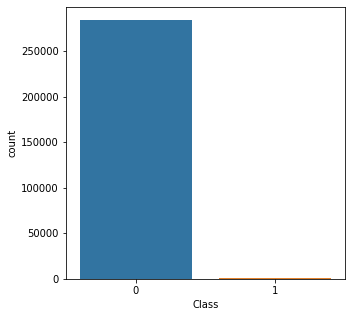

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.countplot(x='Class', data=df)

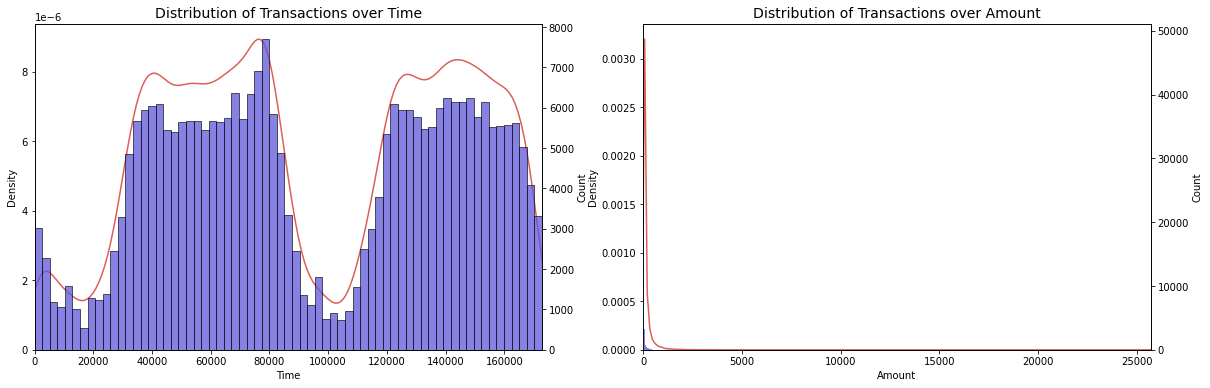

In [21]:
def amount_time_distributions(df):
    _, ax = plt.subplots(1, 2, figsize=(20, 6))
    sns.kdeplot(x='Time', ax=ax[0], data=df, color=cmap[0])
    ax2 = ax[0].twinx()
    sns.histplot(x='Time', ax=ax2, data=df, color=cmap[1])
    ax[0].set_title('Distribution of Transactions over Time', fontsize=14)
    ax[0].set_xlim([min(df['Time']), max(df['Time'])])
    
    sns.kdeplot(x='Amount', ax=ax[1], data=df, color=cmap[0])
    ax2 = ax[1].twinx()
    sns.histplot(x='Amount', ax=ax2, data=df, color=cmap[1])
    ax[1].set_title('Distribution of Transactions over Amount', fontsize=14)
    ax[1].set_xlim([min(df['Amount']), max(df['Amount'])])

    plt.show()

amount_time_distributions(df)

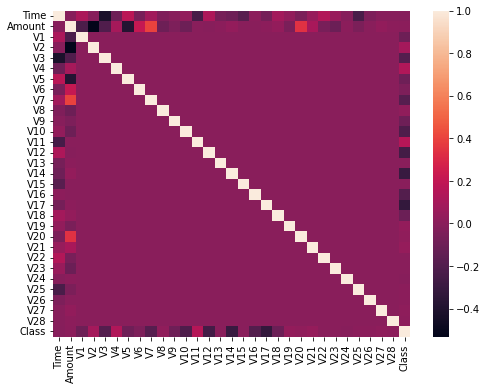

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(df.corr())

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split

X = df.drop(labels=['Class'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

train_nonfraud_len = len(np.where(y_train == 0)[0])
train_fraud_len = len(np.where(y_train == 1)[0])

test_nonfraud_len = len(np.where(y_test == 0)[0])
test_fraud_len = len(np.where(y_test == 1)[0])

print('TRAINING SET')
print('- Fraud class size: {}\n- Non-Fraud class size: {}'.format(train_fraud_len, train_nonfraud_len))
print('% trainset with class 0: {}\n% trainset with class 1: {}\n'.format(train_nonfraud_len / len(y_train) * 100, train_fraud_len / len(y_train) * 100))

print('TESTING SET')
print('- Fraud class size: {}\n- Non-Fraud class size: {}'.format(test_fraud_len, test_nonfraud_len))

print('% testset with class 0: {}\n% testset with class 1: {}\n'.format(test_nonfraud_len / len(y_test) * 100, test_fraud_len / len(y_test) * 100))

TRAINING SET
- Fraud class size: 394
- Non-Fraud class size: 227451
% trainset with class 0: 99.82707542408215
% trainset with class 1: 0.17292457591783889

TESTING SET
- Fraud class size: 98
- Non-Fraud class size: 56864
% testset with class 0: 99.82795547909133
% testset with class 1: 0.17204452090867595



In [26]:
new_df = pd.concat([X_train, y_train], axis=1)
holdout_df = pd.concat([X_test, y_test], axis=1)

In [27]:
new_df = new_df.groupby('Class', group_keys=False).apply(lambda x: x.sample(train_fraud_len))

Distribution of the Classes with Random Undersampling
0    0.5
1    0.5
Name: Class, dtype: float64


Text(0.5, 1.0, 'Balanced Dataset')

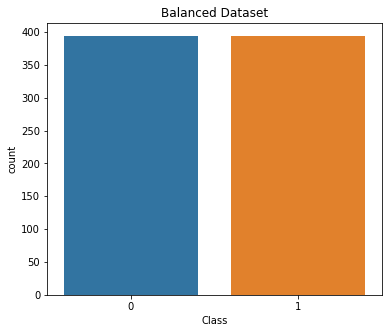

In [28]:
print('Distribution of the Classes with Random Undersampling')
print(new_df['Class'].value_counts()/len(new_df))

fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.countplot(x='Class', data=new_df)
plt.title('Balanced Dataset')

### Correlation Matrix
***
- I wanted to see how the features are correlated. When checking their respective correlations to the Class (Fraudulent or Non-Fraudulent), we notice that features V1-V18 have the strongest correlations.
- Although features like V21 and V22 are strongly negatively correlated, neither seems to be correlated to the Class in any particular way, so this information alone may not be directly useful for predicting the class. 
- I will focus visualizations on the features which have the weak $\rightarrow$ strong correlation with the Class (<= -0.65 or >= 0.5):
    - The specific intervals were chosen to get even samples from both positively and negatively correlated features.

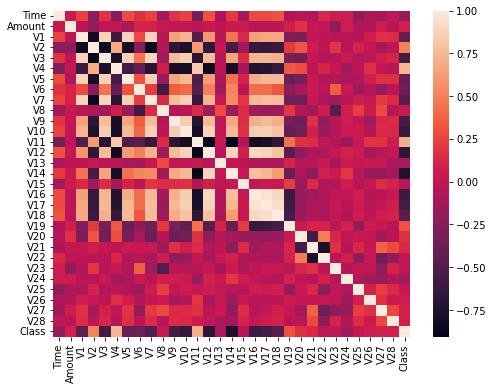

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(new_df.corr())

In [30]:
new_df = create_class_names(new_df)
new_df = create_class_distribution(new_df)

NameError: name 'create_class_names' is not defined

In [ ]:
def get_high_corr_feats(df, upper_bound=0.6, lower_bound=-0.6, excluded_feats=['Class', 'Class Name', 'Class Dist'], summary=True):
    class_corr = df.corr()['Class']
    # don't include class for this (1 correlation with itself)
    pos_corr_feats = class_corr.loc[(class_corr >= upper_bound) & (~class_corr.index.isin(excluded_feats))]
    neg_corr_feats = class_corr.loc[(class_corr <= lower_bound)]
    
    if summary:
        print('Features Positively Correlated with Class')
        for idx in pos_corr_feats.index:
            print(idx, pos_corr_feats[idx])
        
        print('\nFeatures Negatively Correlated with Class')
        for idx in neg_corr_feats.index:
            print(idx, neg_corr_feats[idx])
    
    return pos_corr_feats, neg_corr_feats
    

def create_class_names(df, col='Class Name'):
    df.loc[df['Class'] == 1, col] = 'Fraud'
    df.loc[df['Class'] == 0, col] = 'Non-Fraud'
    
    return df

def create_class_distribution(df, col='Class Dist'):
    zero_class_dist = np.random.normal(loc=0, scale=0.1, size=len(df)//2)
    one_class_dist = np.random.normal(loc=1, scale=0.1, size=len(df)//2)

    df.loc[df['Class'] == 0, col] = zero_class_dist
    df.loc[df['Class'] == 1, col] = one_class_dist
    
    return df

In [ ]:
pos_corr_feats, neg_corr_feats = get_high_corr_feats(new_df, upper_bound=0.6, lower_bound=-0.6)

Features Positively Correlated with Class
V4 0.7029447689198168
V11 0.6857762590425132

Features Negatively Correlated with Class
V10 -0.6249021543040049
V12 -0.6725350769986648
V14 -0.748837028913863


In [ ]:
def plot_joint_distribution(df, corr_feats, x_label='Class Dist', hue='Class Name'):
    fig, axs = plt.subplots(1, len(corr_feats), figsize=(15, 5))
    for i, feat in enumerate(corr_feats.index):
        sns.kdeplot(data=df, x=x_label, y=feat, ax=axs[i], hue=hue, palette=cmap)
        axs[i].set_title('{} vs. Class Distribution - Correlation: {}'.format(feat, round(corr_feats[feat], 3)))
        plt.suptitle('Joint Distribution of Features and Class\nPositive Correlation with Class')

    plt.tight_layout(w_pad=5.0)
    plt.show()

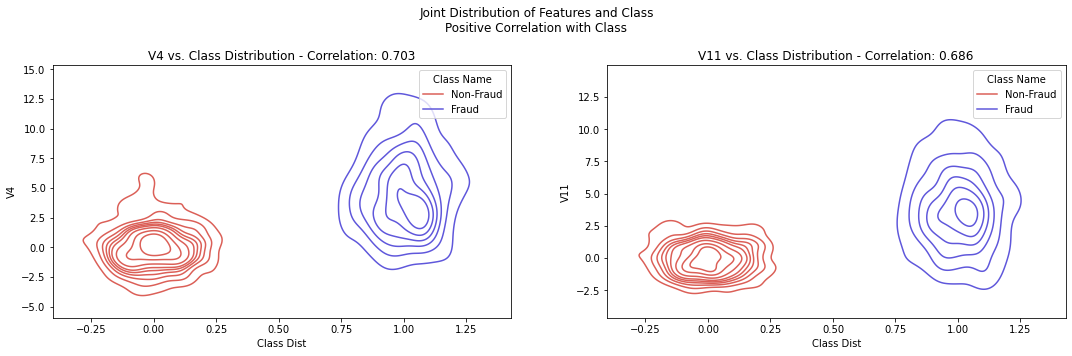

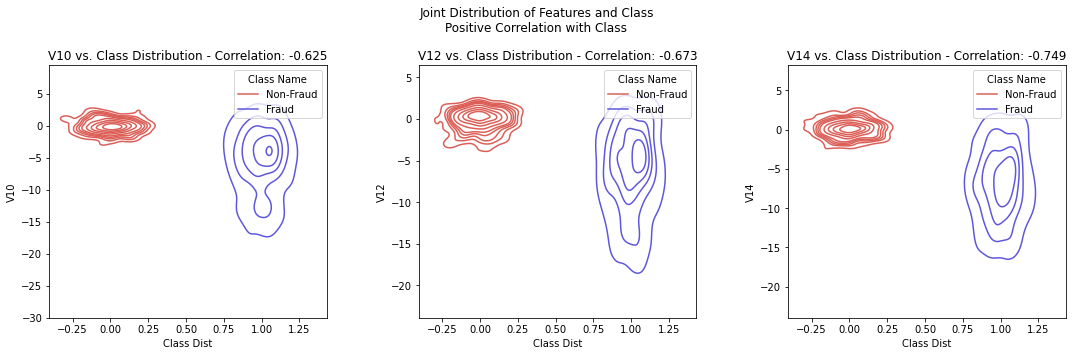

In [ ]:
plot_joint_distribution(new_df, pos_corr_feats)
plot_joint_distribution(new_df, neg_corr_feats)

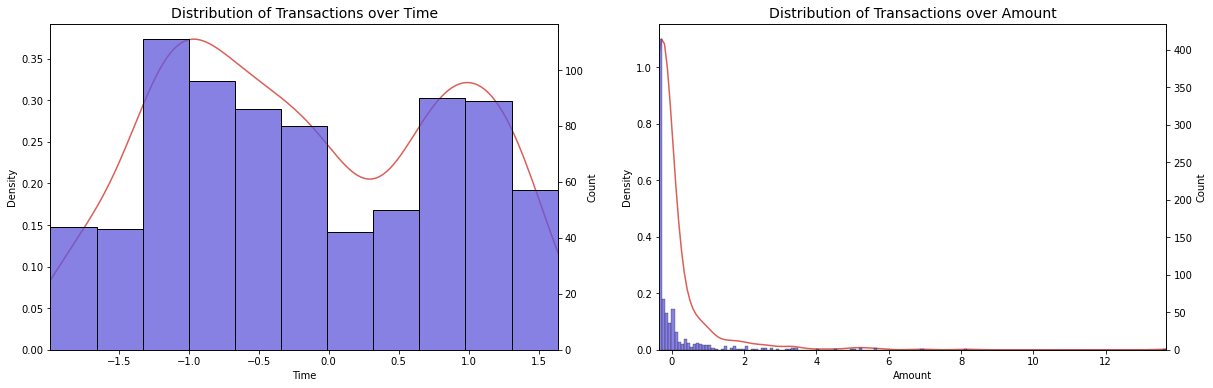

In [ ]:
amount_time_distributions(new_df)

In [ ]:
def get_irq_from_dataframe(df):
    lower_quartile = df.quantile(0.25)
    upper_quartile = df.quantile(0.75)
    return upper_quartile - lower_quartile, lower_quartile, upper_quartile

def trim_outliers(df, irq, lower_quartile, upper_quartile, slice, threshold=1.5):
    lower_bound = lower_quartile - threshold * irq
    upper_bound = upper_quartile + threshold * irq

    outlier_indices = slice[(slice > upper_bound) | (slice < lower_bound)].index
    
    df = df.drop(outlier_indices)

    return df, lower_bound, upper_bound

def show_outliers(df, lower_bound, upper_bound, slice):
    outlier_indices = slice[(slice > upper_bound) | (slice < lower_bound)].index
    noutliers = len(outlier_indices)
    
    outliers = [x for x in slice[outlier_indices]]
    
    print('{} # outliers: {}, {}'.format(slice.name, len(outliers), noutliers))
    print('{} outliers: {}'.format(slice.name, outliers))
    
def trim_outliers_from_corr_features(df, corr_feats, threshold=1.5, summary=True):
    trimmed_df = df.copy()
    for feats in corr_feats:
        for feat in feats.index:
            feat_fraud = trimmed_df[feat].loc[trimmed_df['Class'] == 1]
            irq, lower_quartile, upper_quartile = get_irq_from_dataframe(feat_fraud)
            
            if summary:
                print(f'FEATURE {feat}:')
                print('Dataset size (pre-trim): ', len(trimmed_df))
                print('\nInterquartile Range: {}\nQuartiles: {}\n'.format(irq, [lower_quartile, upper_quartile]))
                
            trimmed_df, lower_bound, upper_bound = trim_outliers(trimmed_df, irq, lower_quartile, upper_quartile, slice=feat_fraud, threshold=threshold)
            show_outliers(trimmed_df, lower_bound, upper_bound, slice=feat_fraud)
            
            if summary:
                print('Bounds: {}\n'.format([lower_bound, upper_bound]))
                print('Dataset size (post-trim): ', len(trimmed_df))
                print('---'*45)
    
    return trimmed_df

def plot_outliers_removed(df, feats, corr_label='Positively'):
    fig, axs = plt.subplots(1, len(feats), figsize=(5*len(feats),5))
    
    for i, feat in enumerate(feats.index):
        sns.boxplot(x="Class", y=feat, data=df, ax=axs[i], palette=cmap)
        axs[i].set_title(f"{feat} Feature Distribution\nOutliers Removed", fontsize=14)
        axs[i].legend(handles=[nonfraud_patch, fraud_patch])
        
    plt.suptitle(f'Features {corr_label} Correlated with Class')
    plt.tight_layout(w_pad=5.0)
    plt.show()

In [ ]:
trimmed_df = trim_outliers_from_corr_features(new_df, corr_feats=[pos_corr_feats, neg_corr_feats], threshold=1.5, summary=True)

FEATURE V4:
Dataset size (pre-trim):  788

Interquartile Range: 4.019608240633355
Quartiles: [2.3458752213207226, 6.365483461954077]

V4 # outliers: 0, 0
V4 outliers: []
Bounds: [-3.6835371396293097, 12.39489582290411]

Dataset size (post-trim):  788
---------------------------------------------------------------------------------------------------------------------------------------
FEATURE V11:
Dataset size (pre-trim):  788

Interquartile Range: 3.3728651335838453
Quartiles: [1.9913606347158799, 5.364225768299725]

V11 # outliers: 4, 4
V11 outliers: [11.152490598583698, 11.228470279576001, 11.277920727806698, 12.018913181619899]
Bounds: [-3.067937065659888, 10.423523468675494]

Dataset size (post-trim):  784
---------------------------------------------------------------------------------------------------------------------------------------
FEATURE V10:
Dataset size (pre-trim):  784

Interquartile Range: 5.061178056150726
Quartiles: [-7.773134584530778, -2.7119565283800524]

V10 # o

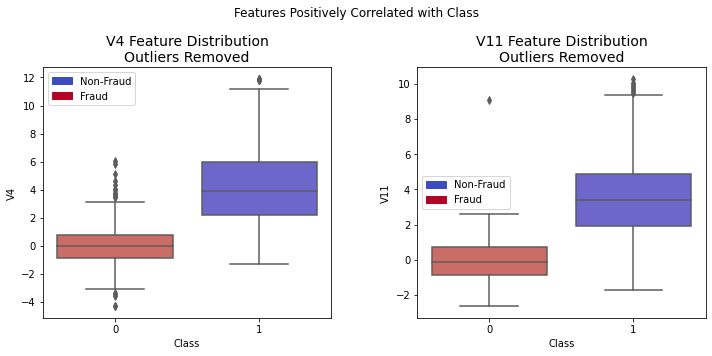

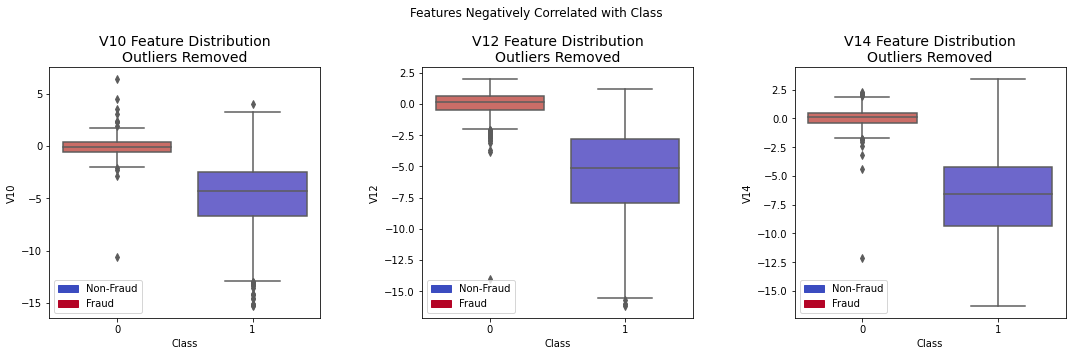

In [ ]:
plot_outliers_removed(trimmed_df, pos_corr_feats, corr_label='Positively')
plot_outliers_removed(trimmed_df, neg_corr_feats, corr_label='Negatively')

In [ ]:
def plot_reduced_dimensions(df, method='tsne'):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    fig.suptitle('Dimensionality Reduction Clustering Visualization')

    X = df.drop(['Class', 'Class Name', 'Class Dist'], axis=1)
    y = df['Class']

    if method == 'tsne':
        X_tsne = TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=40).fit_transform(X)
        ax.scatter(X_tsne[:, 0], X_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Non-Fraud')
        ax.scatter(X_tsne[:, 0], X_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud')
        ax.set_title('t-SNE')
        ax.legend(handles=[nonfraud_patch, fraud_patch])
        plt.show()
        
        return X_tsne
    
    elif method == 'pca':
        X_pca = PCA(n_components=2).fit_transform(X)
        ax.scatter(X_pca[:, 0], X_pca[:,1], c=(y == 0), cmap='coolwarm', label='Non-Fraud')
        ax.scatter(X_pca[:, 0], X_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud')
        ax.set_title('PCA')
        ax.legend(handles=[nonfraud_patch, fraud_patch])
        
        return X_pca
    
    else:
        print('Error: Invalid dimensionality reduction method. Please choose a method from ["tsne", "pca"].')
    
    return None

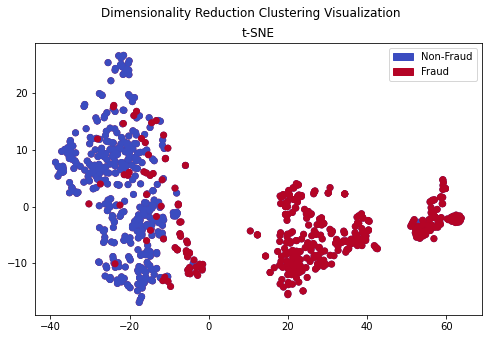

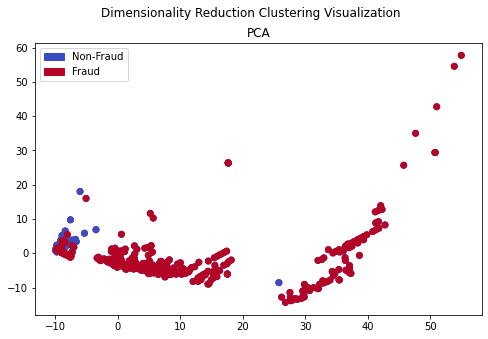

In [ ]:
X_tsne = plot_reduced_dimensions(new_df, method='tsne')
X_pca = plot_reduced_dimensions(new_df, method='pca')


III. <b>Random UnderSampling and Oversampling</b><br>
a) [Distributing and Correlating](#correlating)<br>


correlating
<a id="correlating"></a>
